In [1]:
import csv
from collections import Counter
from itertools import dropwhile
from scipy.sparse import dok_matrix
import scipy.sparse
import numpy as np
import pandas as pd
%matplotlib inline
import math
import os
import re
import random
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.optim
from tqdm import tqdm
from sklearn.metrics import f1_score

In [2]:
party_affiliation_dict = {"Democratic Party": 0, "Republican Party": 1}
def get_party_id(name):
    return party_affiliation_dict[name]
party_name_dict = {str(value): key for key,value in party_affiliation_dict.items()}
def get_party_name1(id):
    return party_name_dict[str(int(id))]
def get_party_name(id):
    return party_name_dict[str(int(id[0]))]

In [3]:
def tokenize(sentence):
    return sentence.split(" ")

In [4]:
def better_tokenize(sentence):
    word_list = re.findall("[a-zA-z]+", sentence)
    return [word.lower() for word in word_list]

In [5]:
def sigmoid(x):
    return 1/(1+ math.exp(-x))

In [6]:
def build_term_document_matrix(file_path):
    raw_words_counter= Counter()
    train_data = pd.read_csv(file_path)
    train_data.head()
    train_data['party_affiliation'] = train_data['party_affiliation'].apply(get_party_id)
    train_data['email_text'] = train_data['email_text'].apply(better_tokenize)
    train_data.head()
    for _list in train_data['email_text']:
        for word in _list:
            raw_words_counter[word] += 1
    filtered_word_counter = Counter({word: count for word, count in raw_words_counter.items() if count >= 10})
    frequent10_words_list = list(filtered_word_counter.keys())
    term_document_matrix = dok_matrix((len(train_data), len(frequent10_words_list)), dtype=np.float32)
    row_index = 0
    for _list in train_data['email_text']:
        row_counter = Counter()
        for word in _list:
            if word in frequent10_words_list:
                row_counter[word] += 1
        for word, count in row_counter.items():
            term_document_matrix[row_index, frequent10_words_list.index(word)] = count
        row_index += 1
    display(term_document_matrix)
    y_truth = train_data['party_affiliation'].to_numpy()
    return term_document_matrix, y_truth, frequent10_words_list
training_term_document_matrix, y_truth, frequent10_words_list = build_term_document_matrix('train.csv')

<59999x12360 sparse matrix of type '<class 'numpy.float32'>'
	with 9927415 stored elements in Dictionary Of Keys format>

In [7]:
training_term_document_matrix = training_term_document_matrix.asformat('csr')
scipy.sparse.save_npz('training_matrix.npz', training_term_document_matrix)

In [8]:
training_term_document_matrix = scipy.sparse.load_npz('training_matrix.npz')

In [9]:
def log_likelihood(x, parameter, y_truth):
    # x is a (D * V) matrix
    # parameter is a (V * 1) matrix
    # y_truth is a (D * 1) matrix
    ll = 0
    for i in range(x.shape[0]):
        ll += y_truth[i] * (x[i,:].dot(parameter)).transpose() - np.log(1 + np.exp((x[i,:].dot(parameter)).transpose()))
    return ll

In [10]:
def compute_gradient(x, parameter, y_truth):
    # this is for stochastic gradient descent
    # x is one row of big x
    # y_truth is a row of y_truth
    delta_parameter = (sigmoid(x.dot(parameter)) - y_truth) * np.transpose(x)
    return delta_parameter

In [11]:
# add bias column to training_x
x = training_term_document_matrix
row, column = x.shape
# bias
parameters = np.zeros((column + 1, 1))
display(parameters.shape)
bias_column = dok_matrix([[1] for i in range(row)])
display(bias_column.ndim)
# bias_column = bias_column[:, np.newaxis]
# display(bias_column.ndim)
display(x.ndim)
x = scipy.sparse.hstack([x, bias_column], "csr")
display(x.shape)

(12361, 1)

2

2

(59999, 12361)

0

100

200

300

400

500

600

700

800

900

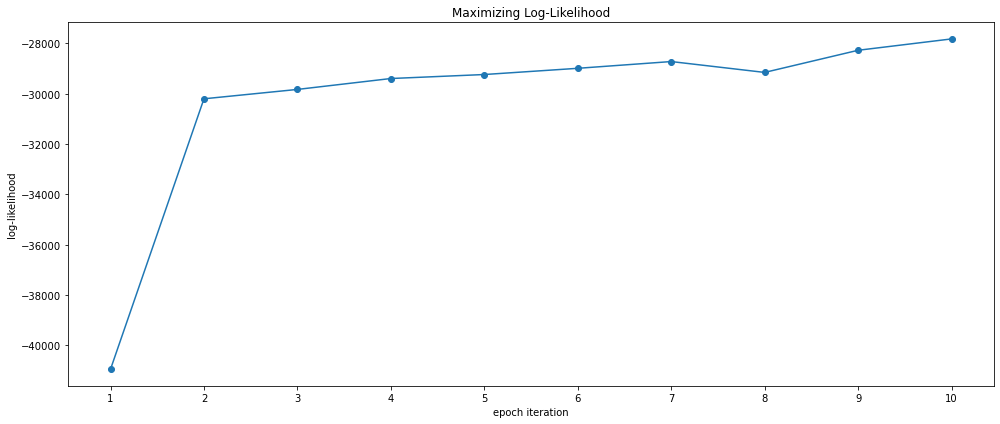

In [13]:
# training and plotting
# ploting part refers to 
# https://towardsdatascience.com/understand-implement-logistic-regression-in-python-c1e1a329f460 by Do Lee
def logistic_regression(x, y_truth, parameters):
    learning_rate = 5e-5
    epoch_length = 100
    num_step = 1000
    log_likelihood_epoch = []
    for i in range(num_step):
        r = random.choice(range(row))
        parameters -= learning_rate * compute_gradient(x[r, :], parameters, y_truth[r])
        if i % epoch_length == 0:
            log_likelihood_epoch.append(log_likelihood(x, parameters, y_truth)[0,0])
            display(i)
    x_axis = [i for i in range(1, len(log_likelihood_epoch) + 1)]
    plt.figure(figsize=(14,6))
    plt.title('Maximizing Log-Likelihood')
    plt.xticks(x_axis)
    plt.xlabel('epoch iteration')
    plt.ylabel('log-likelihood')
    plt.plot(x_axis, log_likelihood_epoch, marker='o')
    plt.tight_layout()
    return parameters
parameters = logistic_regression(x, y_truth, parameters)

In [14]:
# validation
validation_data = pd.read_csv('dev.csv')
validation_data['party_affiliation'] = validation_data['party_affiliation'].apply(get_party_id)
validation_data['email_text'] = validation_data['email_text'].apply(better_tokenize)
term_document_matrix = dok_matrix((len(validation_data), len(frequent10_words_list)), dtype=np.float32)
row_index = 0
for _list in validation_data['email_text']:
    row_counter = Counter()
    for word in _list:
        if word in frequent10_words_list:
            row_counter[word] += 1
    for word, count in row_counter.items():
        term_document_matrix[row_index, frequent10_words_list.index(word)] = count
    row_index += 1
# bias
bias_column = dok_matrix([[1] for i in range(len(validation_data))])
display(bias_column.shape)
display(term_document_matrix.shape)
validation_term_document_matrix = term_document_matrix.asformat('csr')
scipy.sparse.save_npz('dev_matrix.npz', validation_term_document_matrix)
term_document_matrix = scipy.sparse.hstack([validation_term_document_matrix, bias_column], "csr")
display(term_document_matrix.shape)

(20000, 1)

(20000, 12360)

(20000, 12361)

In [ ]:
# parameters = np.loadtxt('parameters_100000.txt')

In [15]:
term_document_matrix = scipy.sparse.load_npz('dev_matrix.npz')
term_document_matrix = scipy.sparse.hstack([term_document_matrix, bias_column], "csr")
prediction_y = np.around(1/(1+ np.exp(-term_document_matrix.dot(parameters))))
validate_truth_y = validation_data['party_affiliation'].values.reshape((len(validation_data), 1))
# difference = np.sum(np.absolute(prediction_y - validation_data['party_affiliation'].values.reshape((len(validation_data), 1))))
# difference
f1_score(validate_truth_y, prediction_y)

0.0

In [16]:
def predict(parameters, string, word_list):
    '''
    parameters: beta
    string: text to be predicted
    word_list: the list of words which has frequency >=10
    '''
    term_document_list = []
    words = better_tokenize(string)
    counter = Counter(words)
    predict_x= np.zeros((1, len(word_list)))
    bias_column = np.ones((1, 1))
    predict_x = np.concatenate((predict_x, bias_column), axis=1)
    for k, c in counter.items():
        if k in word_list:
            predict_x[0, word_list.index(k)] = c
    if 1/(1+ np.exp(-predict_x * parameters))[0,0] < 0.5:
        label = get_party_name1(0)
    else:
        label = get_party_name1(1)
    return label

In [17]:
sample = '''We simply could not run our campaign without our fantastic fellows! This year, over forty fellows ahave been valuable members of our team, working to reach voters and help us come with new ideas for h <> <> for <ORG> 
  We simply could not run our campaign without our fantastic fellows! This year, over forty fellows have been valuable members of our team, working in all facets of the operation. This year, the campaign has leaned on them more to help us think through how to creatively reach young voters in the <DATE>- era. <> believes that it â€™s critical for our campaign to train the next generation of <GPE> â€™s political leaders, and in that spirit, our fellows had a front- row seat in learning about the operations of a serious political campaign. The team also provided the fellows with professional development training from experts, campaign staff, and of course <LAW> herself! 
  Our fellows took some time to write about why they chose to join our campaign. Read what three of them had to say below: 
*** 
  <> â€™s message spoke to me as I too felt passionately about the cost of healthcare. In 2017, my mom was diagnosed with end stage renal disease and began dialysis. The week before I joined the campaign, my mom â€™s doctors also found multiple cancerous soft tissue tumors. With the <ORG> still in place due to <> <> â€™s work, my mom continues to be insured, even though she has a preexisting condition. 
  <> <> 
 <> <>, <> 
 I made the decision to work for <> <> â€™s reelection campaign because, in a district where one neighbor has a <PERSON> sign in their yard and the next house has a <PRODUCT> flag flying, we ca nâ€™t have a representative who ostracizes those who do nâ€™t think exactly like them. We need someone who will give us the facts and explain why she feels that a certain decision is right for the district at large. Congresswoman <> made this promise to us as her constituents and has upheld it during a turbulent freshman term. 
  <> <> 
 <> <>, <> 
  When I unexpectedly found myself spending yet another summer in the town that I grew up in, I knew that I had to do things differently and really find meaning and purpose this year. After deciding that I wanted to spend my time and energy working in politics I knew there was only one campaign and candidate that truly embodied my vision for <GPE> and <GPE>. Congresswoman <> is so amazing to work for because she is a different type of leader who exists to serve her constituents whether they agree with everything she does or not. In the time I â€™ve spent as a fellow on the team this summer I â€™ve been able to see in action a true <NORP> <NORP> who prioritizes organized labor and the equality of all people. The zoom calls, events, and phone banks never really feel like work but more like an opportunity to be responsible for even just a little part of the re - election effort. The other fellows and I are so appreciative to get this opportunity to work for someone who chooses country over party, tangible change over rhetoric, and her district over corporate PACs. 
  <> <> 
 <> <>, <> 
  Thanks for reading, and thanks for all of your support. 
  <> <> 
 contribute 
 About <> 
  <> <> proudly represents <GPE> â€™s 8th district in <ORG>. Keep up with <PRODUCT> and the latest from the campaign trail on <> and   <>. 
 [[ URL <>]] 
  <> <> 
  Paid for by <> <> for <ORG> 
  This email was sent to[[ EMAIL_REDACTED]] Click here to unsubscrib'''
predict(parameters, sample, frequent10_words_list)

'Democratic Party'

# generate csv to kaggle

In [ ]:
# generate csv to kaggle
# test_data = pd.read_csv('test.csv')
# test_data['email_text'] = test_data['email_text'].apply(better_tokenize)
# test_term_document_matrix = dok_matrix((len(test_data), len(frequent10_words_list)), dtype=np.float32)
# row_index = 0
# for _list in test_data['email_text']:
#     row_counter = Counter()
#     for word in _list:
#         if word in frequent10_words_list:
#             row_counter[word] += 1
#     for word, count in row_counter.items():
#         test_term_document_matrix[row_index, frequent10_words_list.index(word)] = count
#     row_index += 1
# bias_column = dok_matrix([[1] for i in range(len(test_data))])
# display(bias_column.shape)
# display(test_term_document_matrix.shape)
# test_term_document_matrix = test_term_document_matrix.asformat('csr')

In [ ]:
# generate csv to kaggle
# test_term_document_matrix = test_term_document_matrix.asformat('csr')
# scipy.sparse.save_npz('test_matrix.npz', test_term_document_matrix)
# test_term_document_matrix = scipy.sparse.hstack([test_term_document_matrix, bias_column], "csr")
# display(test_term_document_matrix.shape)

In [ ]:
# generate csv to kaggle
# x_test = test_term_document_matrix
# parameters = np.loadtxt("./parameters_30000.txt")
# out_data = np.around(1/(1+ np.exp(-test_term_document_matrix.dot(parameters)))).tolist()
# party_id = pd.Series(out_data)
# test_data = test_data.drop(columns=['email_text'])
# party_name = party_id.apply(get_party_name)
# test_data['party_affiliation'] = party_name
# test_data.to_csv('./barebone_test.csv', index=False)

Pytorch

In [18]:
def to_sparse_tensor(matrix):
    matrix = matrix.tocoo()
    return torch.sparse_coo_tensor([matrix.row, matrix.col], matrix.data, size=matrix.shape).to(torch.float)

In [19]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        y = torch.sigmoid(self.linear(x))
        return y

In [20]:
training_term_document_matrix = scipy.sparse.load_npz('training_matrix.npz')
train_data = pd.read_csv('train.csv')
train_data['party_affiliation'] = train_data['party_affiliation'].apply(get_party_id)
training_y_truth = train_data['party_affiliation'].to_numpy()
validation_term_document_matrix = scipy.sparse.load_npz('dev_matrix.npz')
validation_data = pd.read_csv('dev.csv')
validation_data['party_affiliation'] = validation_data['party_affiliation'].apply(get_party_id)
validation_y_truth = validation_data['party_affiliation'].to_numpy()

In [21]:
# the accuracy calculate part refers to 
# https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be by Denny Loevlie
epochs = 1000
learning_rate = 5e-2
input_dim = training_term_document_matrix.shape[1]
output_dim = 1
model = LogisticRegression(input_dim, output_dim)
loss = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
x_training = to_sparse_tensor(training_term_document_matrix)
y_training = torch.Tensor(training_y_truth)
x_test = to_sparse_tensor(validation_term_document_matrix)
y_test = torch.Tensor(validation_y_truth)
losses = []
losses_test = []
Iterations = []
f1_scores_test = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = x_training
    labels = y_training
    optimizer.zero_grad()
    outputs = model(x)
    output = loss(torch.squeeze(outputs), labels)
    output.backward()
    optimizer.step()
    iter+=1
    if iter% 100==0:
        # calculate Accuracy
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(x_test))
            loss_test = loss(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            # display(predicted_test.shape)
            # display(y_test.detach().shape)
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_training.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_training.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(output.item())
            Iterations.append(iter)
            test_f1_score = f1_score(y_test.detach().numpy(), predicted_test)
            f1_scores_test.append(test_f1_score)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {output.item()}. Accuracy: {accuracy}\n")
            print(f"F1-score: {test_f1_score}")



C:\Users\fangz\AppData\Local\Temp/ipykernel_12556/264492334.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  return torch.sparse_coo_tensor([matrix.row, matrix.col], matrix.data, size=matrix.shape).to(torch.float)
Training Epochs:  10%|██████▏                                                       | 100/1000 [00:56<08:41,  1.73it/s]

Iteration: 100. 
Test - Loss: 0.637696385383606. Accuracy: 76.225
Train -  Loss: 0.4344722032546997. Accuracy: 85.40309005150085

F1-score: 0.6123114553607828


Training Epochs:  20%|████████████▍                                                 | 200/1000 [01:51<07:47,  1.71it/s]

Iteration: 200. 
Test - Loss: 0.29923155903816223. Accuracy: 87.845
Train -  Loss: 0.41195815801620483. Accuracy: 87.1864531075518

F1-score: 0.7475334925745145


Training Epochs:  30%|██████████████████▌                                           | 300/1000 [02:46<06:31,  1.79it/s]

Iteration: 300. 
Test - Loss: 0.19893211126327515. Accuracy: 91.375
Train -  Loss: 0.22856400907039642. Accuracy: 91.28485474757913

F1-score: 0.8043995917904524


Training Epochs:  40%|████████████████████████▊                                     | 400/1000 [03:40<05:35,  1.79it/s]

Iteration: 400. 
Test - Loss: 0.17264778912067413. Accuracy: 92.575
Train -  Loss: 0.18853284418582916. Accuracy: 92.46654110901848

F1-score: 0.8263767099263416


Training Epochs:  50%|███████████████████████████████                               | 500/1000 [04:36<04:54,  1.70it/s]

Iteration: 500. 
Test - Loss: 0.15292011201381683. Accuracy: 93.505
Train -  Loss: 0.15920813381671906. Accuracy: 93.42822380373006

F1-score: 0.843701118998917


Training Epochs:  60%|█████████████████████████████████████▏                        | 600/1000 [05:32<03:54,  1.71it/s]

Iteration: 600. 
Test - Loss: 0.14239971339702606. Accuracy: 94.125
Train -  Loss: 0.14512361586093903. Accuracy: 94.03990066501109

F1-score: 0.8563394057953294


Training Epochs:  70%|███████████████████████████████████████████▍                  | 700/1000 [06:27<02:58,  1.68it/s]

Iteration: 700. 
Test - Loss: 0.1342218816280365. Accuracy: 94.62
Train -  Loss: 0.13451212644577026. Accuracy: 94.45157419290321

F1-score: 0.8662689535172757


Training Epochs:  80%|█████████████████████████████████████████████████▌            | 800/1000 [07:23<01:57,  1.71it/s]

Iteration: 800. 
Test - Loss: 0.12543311715126038. Accuracy: 94.905
Train -  Loss: 0.12360209971666336. Accuracy: 95.031583859731

F1-score: 0.8700420864685626


Training Epochs:  90%|███████████████████████████████████████████████████████▊      | 900/1000 [08:18<00:54,  1.82it/s]

Iteration: 900. 
Test - Loss: 0.12006638199090958. Accuracy: 95.09
Train -  Loss: 0.11749069392681122. Accuracy: 95.33825563759396

F1-score: 0.8714996074326092


Training Epochs: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [09:12<00:00,  1.81it/s]

Iteration: 1000. 
Test - Loss: 0.11762472242116928. Accuracy: 95.235
Train -  Loss: 0.11475808918476105. Accuracy: 95.49492491541525

F1-score: 0.8743572841133816


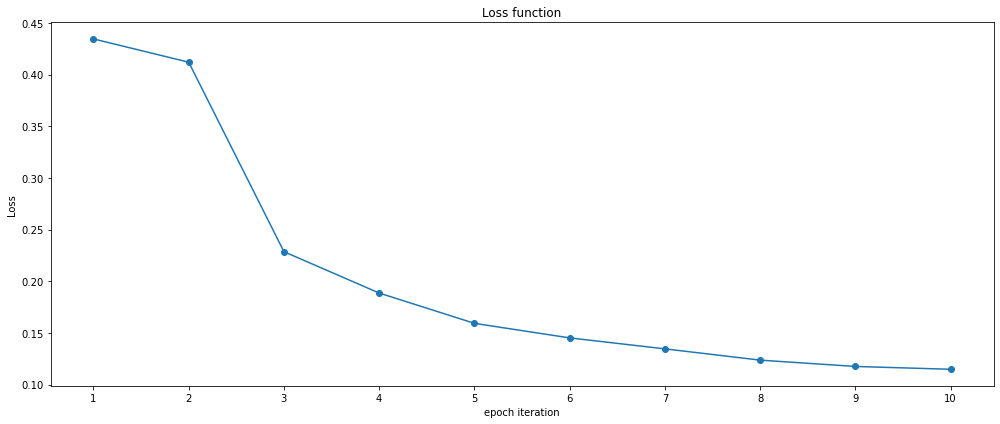

In [23]:
x_axis = [iter for iter in range(1, len(losses) + 1)]
plt.figure(figsize=(14,6))
plt.title('Loss function')
plt.xticks(x_axis)
plt.xlabel('epoch iteration')
plt.ylabel('Loss')
plt.plot(x_axis, losses, marker='o')
plt.tight_layout()

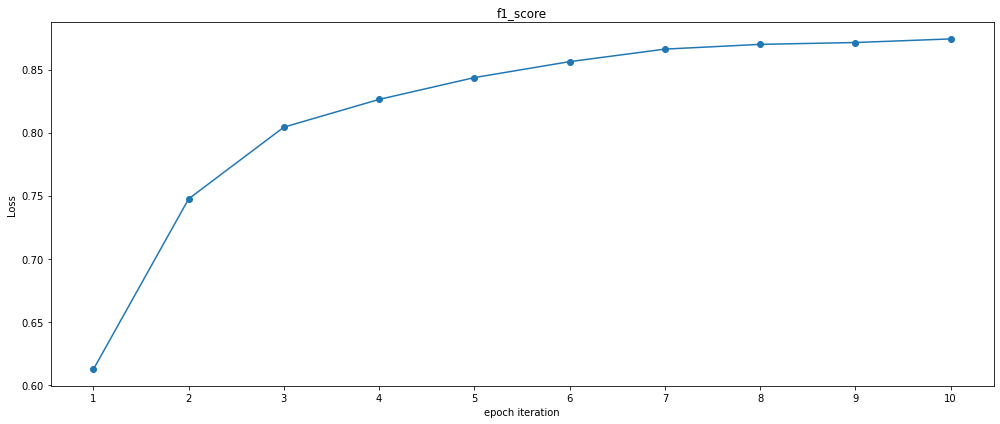

In [24]:
plt.figure(figsize=(14,6))
plt.title('f1_score')
plt.xticks(x_axis)
plt.xlabel('epoch iteration')
plt.ylabel('Loss')
plt.plot(x_axis, f1_scores_test, marker='o')
plt.tight_layout()